# The Dota Games

As a Dota2 player for almost 8 years, I've been enjoying the annual tournament of this game for many times. This year as usual, Valve the developers brought up this Fantasy Challenge for the tournament. Basically this is a card game in which you accrue points by forming a 5-player team every game day, the better your players' performances are, the more points you get. 

As easy as it seems, in order to get more points, you should bet with better players. However, one other factor some might ignore is the game count. Say if team A plays 3 games for this day but team B plays only 2 games, even though team B might have better players, for us point collectors, it really makes more sense to bet with team A players.

Now being a lazy person who happens to be reviewing web scraping at the moment, I decided to write a little program to help me count the games and rankings from the official website.

In [1]:
import urllib.request
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

D:\Programs\Anaconda\lib\importlib\_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


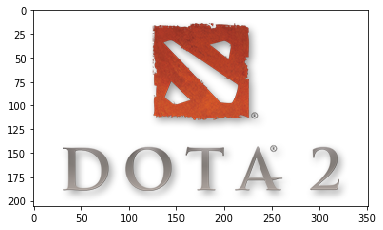

In [2]:
f = urllib.request.urlopen("http://cdn.dota2.com/apps/dota2/images/blog/play/dota_logo.png")
a = plt.imread(f)
plt.imshow(a)
plt.show()

The game can be found here: http://www.dota2.com/play/

In [3]:
game_day = 2
page_url = 'http://www.dota2.com/international/schedule/'

In [4]:
# Get the html string with bs4
page = urllib.request.urlopen(page_url+str(game_day))
soup = BeautifulSoup(page, 'html.parser')

In [5]:
# It's a very large page, so I'll just show the relevant part of it
raw = soup.findAll('script', type = 'text/javascript')
for candidate in raw:
    target = str.find(candidate.text,'schedule')
    if target >= 0:
        break
schedule_data = str.split(candidate.text, 'schedule_data')[1]
[schedule_data, team_data] = str.split(schedule_data, 'team_data')
[team_data, standings_data] = str.split(team_data, 'stream_data')
standings_data = str.split(standings_data, 'standings_data')[1]
standings_data = str.split(standings_data, 'user_language')[0]

In [6]:
print(team_data[:100])
print(schedule_data[:100])
print(standings_data[:100])

'		:	'[{"team_id":3,"team_name":"compLexity Gaming","team_tag":"coL","team_logo":"398960342836468051
'	:	'{"1534521600":[{"name":"","node_id":7,"node_group_id":2,"winning_node_id":0,"losing_node_id":0,
'	:	'[{"name":"Group A","node_group_id":2,"team_standings":[{"standing":1,"team_id":39,"team_name":"


I'm guessing there are better ways to do this for javascript function blocks, 
but for a small project like this, I'm ok with it.

In [7]:
# Looks like we need some parsing. Good thing is they data are wrapped mostly with '{}'s.
team_data = re.findall('{(.+?)}', team_data)
# For schedule data, it is a little less neat than the team data, but it is still parsable.
schedule_data = re.findall('{(.+)}', schedule_data)
schedule_data = re.findall('{(.+?stream_ids.+?)}', schedule_data[0])
# For standings data, it easier cuz they are separated by groups.
standings_data = re.findall('team_standings":\[(.+?)\]', standings_data)

In [8]:
# Get team info
teams = {}
for team_str in team_data:
    team_info = re.split('[:,]+', team_str)
    # Make sure we have complete pairs
    n = len(team_info)
    assert(n%2) == 0
    # Get team id and the rest info into a dictionary
    team_id = int(team_info[1])
    teams[team_id] = {}
    for i in range(1, n//2):
        tag = team_info[i*2][1:-1]
        val = team_info[i*2+1]
        if str.startswith(val,'"'): val = val[1:-1]
        teams[team_id].update({tag: val})

Yes there were 54 teams participated, but only 18 of them made it to this round. We are on the right track!

In [9]:
print(len(teams))

54


In [10]:
# Putting the ranking information in the teams dictionary. Better team still matters!!
for standing_str in standings_data:
    standing_info = re.split('[{}]+', standing_str)
    for sub_info in standing_info:
        if str.find(sub_info, 'team_id') >= 0:
            team_id = int(re.findall('team_id":(.+?),', sub_info)[0])
            # There will be duplicate rankings, i.e. same win/loss
            tmp = re.findall('standing":(.+?),', sub_info)
            if len(tmp):
                tmp = tmp[0]
            else:
                tmp = team_ranking
            team_ranking = int(tmp)
            teams[team_id]['Ranking'] = team_ranking
print(teams[3])

{'team_logo': '398960342836468051', 'team_name': 'compLexity Gaming', 'region': '1', 'invite_type': '4', 'team_tag': 'coL'}


In [11]:
games = {}
for game_str in schedule_data:
    team_ids = [ int(re.findall('team_id_1":(.+?),', game_str)[0]), int(re.findall('team_id_2":(.+?),', game_str)[0]) ]
    team_names = [teams[team_id]['team_name'] for team_id in team_ids]
    for i, team_name in enumerate(team_names):
        if team_name in games:
            games[team_name]['N games'] += 1
            games[team_name]['Against'].append(team_names[int(not i)])
        else:
            games[team_name] = {'N games': 1, 'Against': [team_names[int(not i)]], 'Ranking': teams[team_ids[i]]['Ranking']}

In [12]:
games

{'Evil Geniuses': {'Against': ['Winstrike', 'Team Liquid'],
  'N games': 2,
  'Ranking': 1},
 'Fnatic': {'Against': ['OG', 'PSG.LGD', 'Winstrike'],
  'N games': 3,
  'Ranking': 2},
 'Invictus Gaming': {'Against': ['VGJ Thunder', 'OG', 'PSG.LGD'],
  'N games': 3,
  'Ranking': 4},
 'Mineski': {'Against': ['Team Liquid', 'VGJ Thunder'],
  'N games': 2,
  'Ranking': 4},
 'Newbee': {'Against': ['Virtus.pro', 'VGJ Storm'],
  'N games': 2,
  'Ranking': 4},
 'OG': {'Against': ['Fnatic', 'Invictus Gaming', 'VGJ Thunder'],
  'N games': 3,
  'Ranking': 5},
 'OpTic Gaming': {'Against': ['Team Serenity', 'Team Secret'],
  'N games': 2,
  'Ranking': 6},
 'PSG.LGD': {'Against': ['Fnatic', 'Invictus Gaming'],
  'N games': 2,
  'Ranking': 3},
 'TNC Predator': {'Against': ['VGJ Storm', 'Team Serenity'],
  'N games': 2,
  'Ranking': 2},
 'Team Liquid': {'Against': ['Mineski', 'Winstrike', 'Evil Geniuses'],
  'N games': 3,
  'Ranking': 2},
 'Team Secret': {'Against': ['OpTic Gaming'], 'N games': 1, 'Ranki

All done! With this utility I can quickly get the idea of my Fantasy Challenge strategy, (though it did cost me 3 hours doing it).

In [13]:
def getFantasyStrategy(game_day, page_url = 'http://www.dota2.com/international/schedule/'):
    
    page = urllib.request.urlopen(page_url+str(game_day))
    soup = BeautifulSoup(page, 'html.parser')
    
    # Get schedule chunk
    raw = soup.findAll('script', type = 'text/javascript')
    for candidate in raw:
        target = str.find(candidate.text,'schedule')
        if target >= 0:
            break
            
    # Get team data and schedule data
    schedule_data = str.split(candidate.text, 'schedule_data')[1]
    [schedule_data, team_data] = str.split(schedule_data, 'team_data')
    [team_data, standings_data] = str.split(team_data, 'stream_data')
    standings_data = str.split(standings_data, 'standings_data')[1]
    standings_data = str.split(standings_data, 'user_language')[0]
    
    team_data = re.findall('{(.+?)}', team_data)
    schedule_data = re.findall('{(.+)}', schedule_data)
    schedule_data = re.findall('{(.+?stream_ids.+?)}', schedule_data[0])
    standings_data = re.findall('team_standings":\[(.+?)\]', standings_data)
    
    # Get team info
    teams = {}
    for team_str in team_data:
        team_info = re.split('[:,]+', team_str)
        # Make sure we have complete pairs
        n = len(team_info)
        assert(n%2) == 0
        # Get team id and the rest info into a dictionary
        team_id = int(team_info[1])
        teams[team_id] = {}
        for i in range(1, n//2):
            tag = team_info[i*2][1:-1]
            val = team_info[i*2+1]
            if str.startswith(val,'"'): val = val[1:-1]
            teams[team_id].update({tag: val})
            
    # Putting the ranking information in the teams dictionary. Better team still matters!!
    for standing_str in standings_data:
        standing_info = re.split('[{}]+', standing_str)
        for sub_info in standing_info:
            if str.find(sub_info, 'team_id') >= 0:
                team_id = int(re.findall('team_id":(.+?),', sub_info)[0])
                # There will be duplicate rankings, i.e. same win/loss
                tmp = re.findall('standing":(.+?),', sub_info)
                if len(tmp):
                    tmp = tmp[0]
                else:
                    tmp = team_ranking
                team_ranking = int(tmp)
                teams[team_id]['Ranking'] = team_ranking
            
    # Get game info
    games = {}
    for game_str in schedule_data:
        team_ids = [ int(re.findall('team_id_1":(.+?),', game_str)[0]), int(re.findall('team_id_2":(.+?),', game_str)[0]) ]
        team_names = [teams[team_id]['team_name'] for team_id in team_ids]
        for i, team_name in enumerate(team_names):
            if team_name in games:
                games[team_name]['N games'] += 1
                games[team_name]['Against'].append(team_names[int(not i)])
            else:
                games[team_name] = {'N games': 1, 'Against': [team_names[int(not i)]], \
                                    'Ranking': teams[team_ids[i]]['Ranking']}
    return games

In [16]:
my_data = getFantasyStrategy(2)

In [20]:
df = pd.DataFrame(np.NaN, index = my_data.keys(), columns = ['Game Count', 'Group Standing'])
for this_team in my_data:
    df.loc[this_team,] = [ my_data[this_team]['N games'], my_data[this_team]['Ranking'] ]
df.sort_values(['Game Count', 'Group Standing'], inplace = False, ascending = [False, True])  

,Game Count,Group Standing
Fnatic,3.0,2.0
Team Liquid,3.0,2.0
Invictus Gaming,3.0,4.0
VGJ Thunder,3.0,5.0
OG,3.0,5.0
Winstrike,3.0,6.0
Evil Geniuses,2.0,1.0
VGJ Storm,2.0,1.0
TNC Predator,2.0,2.0
PSG.LGD,2.0,3.0


#### So this will be the games for tomorrow. 
#### Based on my analysis, I'm proposing 3 players from Team Liquid, 1 from Team Invictus Gaming, 1 from Optic Gaming!
#### Currently my score is on the top of my friends' board, hopefully this would help me guard my lead!